<a href="https://colab.research.google.com/github/sdikhit22/project-sp22-skeleton/blob/main/BayesHW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Setup
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from itertools import combinations
from google.colab import drive
drive.mount('/content/drive')
rng = np.random.default_rng(22)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Q1, part A

# --- Load and prepare data ---
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/beetle_counts.csv")
data["color_code"] = data["color"].astype("category").cat.codes
color_idx = data["color_code"].to_numpy()
y_count = data["count"].to_numpy()
n_colors = data["color"].nunique()

# --- Bayesian ANOVA (Normal likelihood) ---
with pm.Model() as m:
    beta0 = pm.Normal("beta0_intercept", mu=y_count.mean(), sigma=10)

    sigma_color = pm.HalfStudentT("sigma_color", nu=3, sigma=5)

    sigma_y = pm.HalfStudentT("sigma_y", nu=3, sigma=10)

    # Sum-to-zero constrained color effects
    color_eff = pm.ZeroSumNormal("color_eff", sigma=sigma_color, shape=n_colors)

    mu = beta0 + color_eff[color_idx]

    y = pm.Normal("y", mu=mu, sigma=sigma_y, observed=y_count)

    trace = pm.sample(draws=5000, tune=2000, target_accept=0.95, random_seed=rng)






Output()

In [3]:
#Q1 part A, used for Q1B as well!
color_names = data["color"].astype("category").cat.categories.tolist()
summary = az.summary(trace, var_names=["color_eff"], hdi_prob=0.95)
summary.index = color_names
summary


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Blue,-6.578,3.383,-13.136,0.177,0.032,0.033,11201.0,7438.0,1.0
Green,-1.232,3.287,-7.544,5.359,0.027,0.037,15065.0,6922.0,1.0
Lemon yellow,23.246,3.720,16.138,30.778,0.038,0.035,9486.0,7518.0,1.0
Orange yellow,1.306,3.419,-5.499,7.953,0.033,0.035,10718.0,7567.0,1.0
Pink,-8.968,3.420,-15.381,-2.102,0.034,0.033,10128.0,7488.0,1.0
Red,2.039,3.414,-4.630,8.631,0.030,0.037,12808.0,8003.0,1.0
White,-9.813,3.422,-16.563,-3.095,0.031,0.033,11974.0,8197.0,1.0


In [4]:
#Q1, Part C

def contrasts(var, index):
    """Calculate differences between levels with names like "alpha[low] - alpha[high]".

    var: pytensor.tensor.var.TensorVariable
    index: pandas.Index
    """
    name = var.name
    for i, j in combinations(range(index.size), 2):
        a, b = index[i], index[j]
        pm.Deterministic(f"{name}[{a}] - {name}[{b}]", var[i] - var[j])


data["color"] = data["color"].astype("category")
data["height_ft"] = data["height_ft"].astype("category")

data["color_code"] = data["color"].cat.codes
data["height_code"] = data["height_ft"].cat.codes

color_idx = data["color_code"].to_numpy()
height_idx = data["height_code"].to_numpy()

coords = {
    "id": np.arange(len(data)),
    "color": data["color"].cat.categories,
    "height": data["height_ft"].cat.categories,
}

with pm.Model(coords=coords) as m2:
    y_data = pm.Data("y_data", data["count"].to_numpy(), dims="id")
    color_idx_data = pm.Data("color_idx_data", color_idx, dims="id")
    height_idx_data = pm.Data("height_idx_data", height_idx, dims="id")

    mu0 = pm.Normal("mu0", mu=0, sigma=10)
    alpha = pm.ZeroSumNormal("alpha", sigma=10, dims="color")
    beta = pm.ZeroSumNormal("beta", sigma=10, dims="height")
    alphabeta = pm.ZeroSumNormal(
        "alphabeta", sigma=10, dims=("color", "height"), n_zerosum_axes=2
    )
    sigma = pm.Exponential("sigma", 0.05)

    mu = mu0 + alpha[color_idx_data] + beta[height_idx_data] + alphabeta[color_idx_data, height_idx_data]
    pm.Normal("y", mu=mu, sigma=sigma, observed=y_data, dims="id")

    contrasts(alpha, coords["color"])
    contrasts(beta, coords["height"])

    trace2 = pm.sample(2000, tune=1000, target_accept=0.95, random_seed = rng)


Output()

In [5]:
#Q1, Part C
az.summary(trace2.posterior, var_names=["mu0", "alpha", "beta", "alphabeta", "sigma", "beta[3] - beta[6]"], hdi_prob = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu0,21.569,1.241,19.132,23.965,0.019,0.019,4436.0,3078.0,1.0
alpha[Blue],-6.767,2.936,-12.554,-1.172,0.044,0.048,4378.0,2836.0,1.0
alpha[Green],-1.205,2.931,-6.811,4.513,0.042,0.047,4903.0,2873.0,1.0
alpha[Lemon yellow],23.812,3.018,17.755,29.539,0.045,0.054,4621.0,2718.0,1.0
alpha[Orange yellow],1.393,2.948,-4.634,7.052,0.044,0.051,4575.0,2901.0,1.0
alpha[Pink],-9.239,2.901,-14.808,-3.374,0.046,0.048,4035.0,2958.0,1.0
alpha[Red],2.094,2.914,-4.043,7.480,0.041,0.045,5023.0,3028.0,1.0
alpha[White],-10.088,2.842,-15.609,-4.479,0.042,0.044,4669.0,3096.0,1.0
beta[3],5.843,1.248,3.498,8.365,0.018,0.021,4617.0,2857.0,1.0
beta[6],-5.843,1.248,-8.365,-3.498,0.018,0.021,4617.0,2857.0,1.0


In [6]:
#Q2A, and Q2B (for intraclass correlation coefficient sampling):
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ortho-5.csv")

y = data["y"].to_numpy()

subject_idx, subjects = pd.factorize(data['Subject'])
coords = {"subject": subjects}
with pm.Model(coords=coords) as m2a:
    #variance=100
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)

    #taus with Gamma(shape=0.01, rate=0.01) -> tau = 1/sigma^2
    tau_e = pm.Gamma("tau_e", alpha=0.01, beta=0.01)
    tau_u = pm.Gamma("tau_u", alpha=0.01, beta=0.01)

    #convert to standard deviations
    sigma_e = pm.Deterministic("sigma_e", pm.math.sqrt(1.0 / tau_e))
    sigma_u = pm.Deterministic("sigma_u", pm.math.sqrt(1.0 / tau_u))

    subj_idx = data["Subject"].astype("category").cat.codes.values
    u = pm.Normal("u", mu=0, sigma=sigma_u, dims="subject")

    # linear predictor
    mu = beta0 + beta1 * data["age"].values + beta2 * data["Sex_coded"].values + u[subj_idx]

    y = pm.Normal("y", mu=mu, sigma=sigma_e, observed=data["y"].values)

    p = pm.Deterministic("p", sigma_u**2 / (sigma_u**2 + sigma_e**2))

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True, random_seed=rng)

Output()

In [7]:
#Q2A) Summary stats
az.summary(trace.posterior, hdi_prob=0.95, var_names=["beta", "sigma"], filter_vars="like")

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,16.472,0.797,14.884,18.007,0.022,0.012,1298.0,1991.0,1.0
beta1,0.666,0.063,0.543,0.785,0.001,0.001,2635.0,3088.0,1.0
beta2,1.147,0.392,0.340,1.891,0.014,0.008,780.0,1269.0,1.0
sigma_e,1.449,0.116,1.223,1.671,0.002,0.002,3022.0,3179.0,1.0
sigma_u,1.858,0.320,1.225,2.471,0.006,0.005,3040.0,2813.0,1.0


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'sigma_e'}>,
        <Axes: title={'center': 'sigma_u'}>, <Axes: >]], dtype=object)

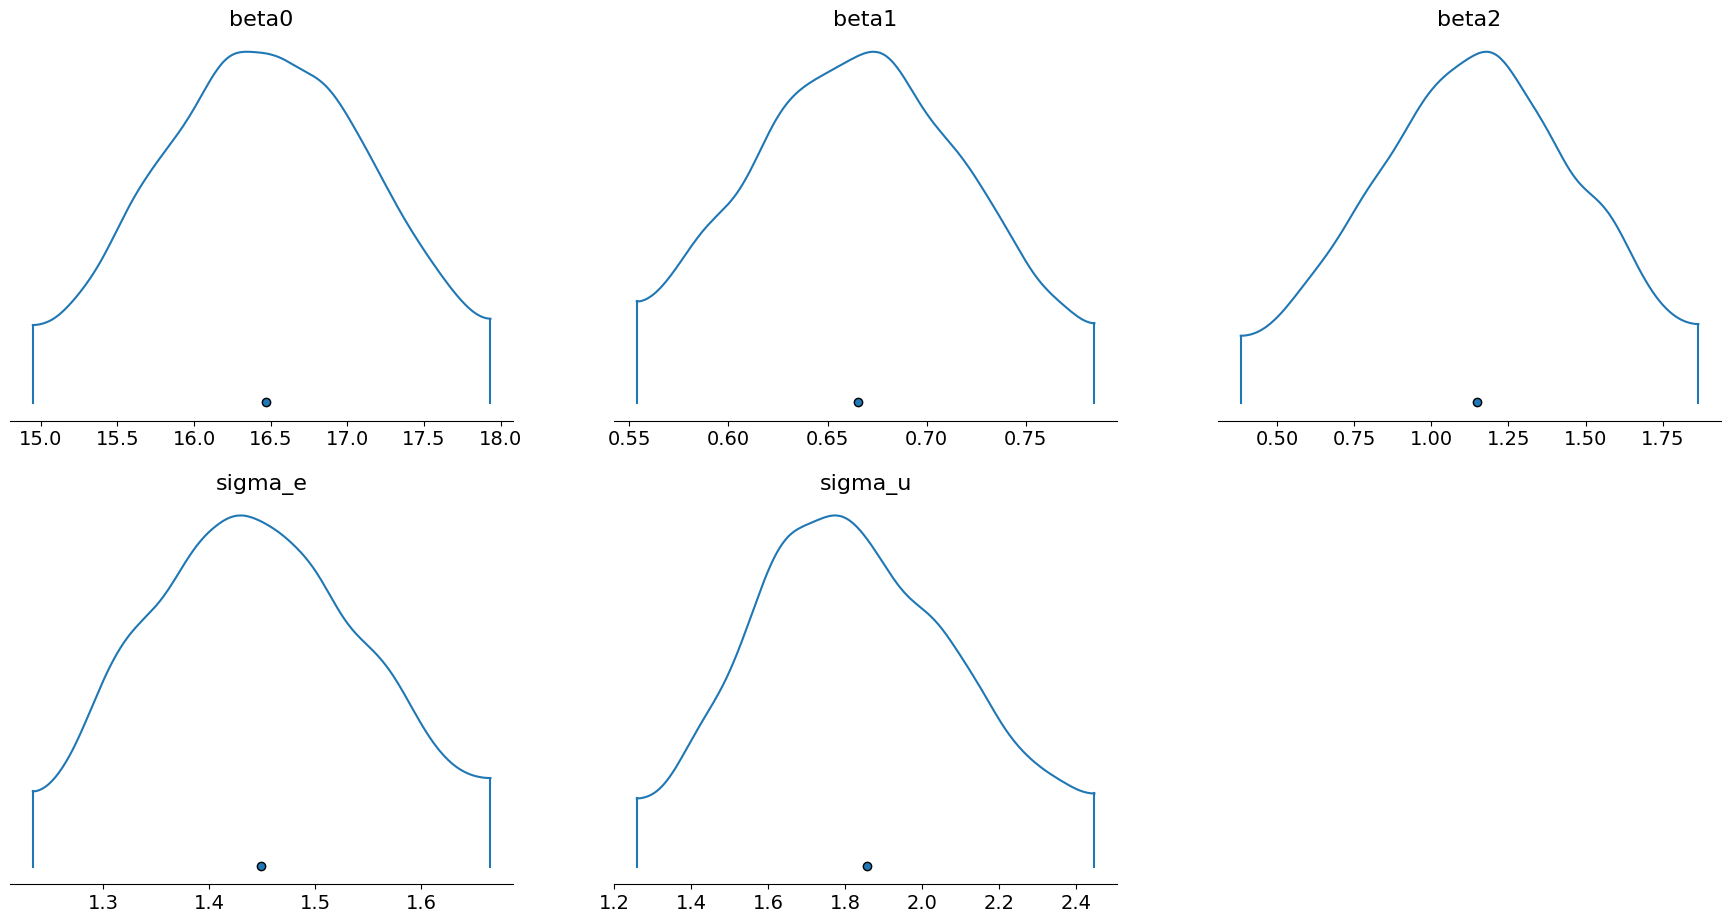

In [8]:
#Q2A) Plots of beta0, beta1, beta2, sigma_e, and sigma_u
az.plot_density(trace.posterior, var_names=["beta0", "beta1", "beta2", "sigma_e", "sigma_u"])

In [9]:
#Q2B (sampled rho in Q2 part a), Summary stats:
az.summary(trace.posterior, hdi_prob=0.95, var_names=["p"], filter_vars="like")

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.613,0.09,0.44,0.786,0.002,0.001,2990.0,2733.0,1.0


array([[<Axes: title={'center': 'p'}>]], dtype=object)

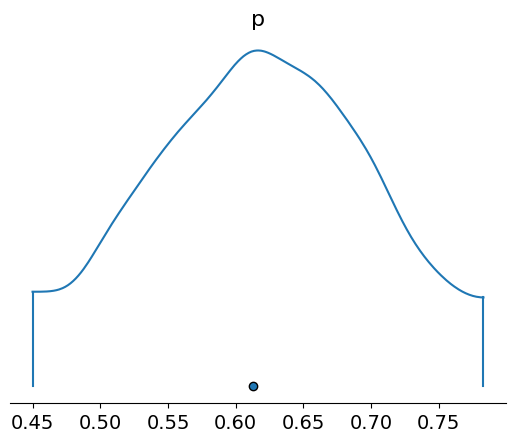

In [10]:
#Q2B (plots)
az.plot_density(trace.posterior, var_names=["p"])

In [11]:
#Q2C)
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ortho-5.csv")

y = data["y"].to_numpy()

subject_idx, subjects = pd.factorize(data['Subject'])
coords = {"subject": subjects}
with pm.Model(coords=coords) as m3:
    #variance=100
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)

    #taus with Gamma(shape=0.01, rate=0.01) -> tau = 1/sigma^2
    tau_e = pm.Gamma("tau_e", alpha=0.01, beta=0.01)
    #tau_u = pm.Gamma("tau_u", alpha=0.01, beta=0.01)

    #convert to standard deviations
    sigma_e = pm.Deterministic("sigma_e", pm.math.sqrt(1.0 / tau_e))
    sigma_u = pm.Deterministic("sigma_u", pm.math.constant(0))

    subject_idx = data["Subject"].astype("category").cat.codes.values
    u = pm.Deterministic("u", pm.math.zeros(len(np.unique(data["Subject"]))))

    # linear predictor
    mu = beta0 + beta1 * data["age"].values + beta2 * data["Sex_coded"].values + u[subject_idx]

    y = pm.Normal("y", mu=mu, sigma=sigma_e, observed=data["y"].values)

    p = pm.Deterministic("p", sigma_u**2 / (sigma_u**2 + sigma_e**2))

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True, random_seed=rng)

Output()

In [12]:
#Q2C: Summary stats of beta0, beta1, beta2, and sigma_e
az.summary(trace.posterior, hdi_prob=0.95, var_names=["beta", "sigma_e"], filter_vars="like")

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,16.302,1.110,14.008,18.341,0.024,0.019,2121.0,2181.0,1.0
beta1,0.681,0.099,0.487,0.871,0.002,0.002,2081.0,2228.0,1.0
beta2,1.158,0.223,0.710,1.590,0.004,0.004,2664.0,2306.0,1.0
sigma_e,2.282,0.161,1.975,2.594,0.003,0.004,2667.0,1970.0,1.0


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'sigma_e'}>, <Axes: >, <Axes: >]],
      dtype=object)

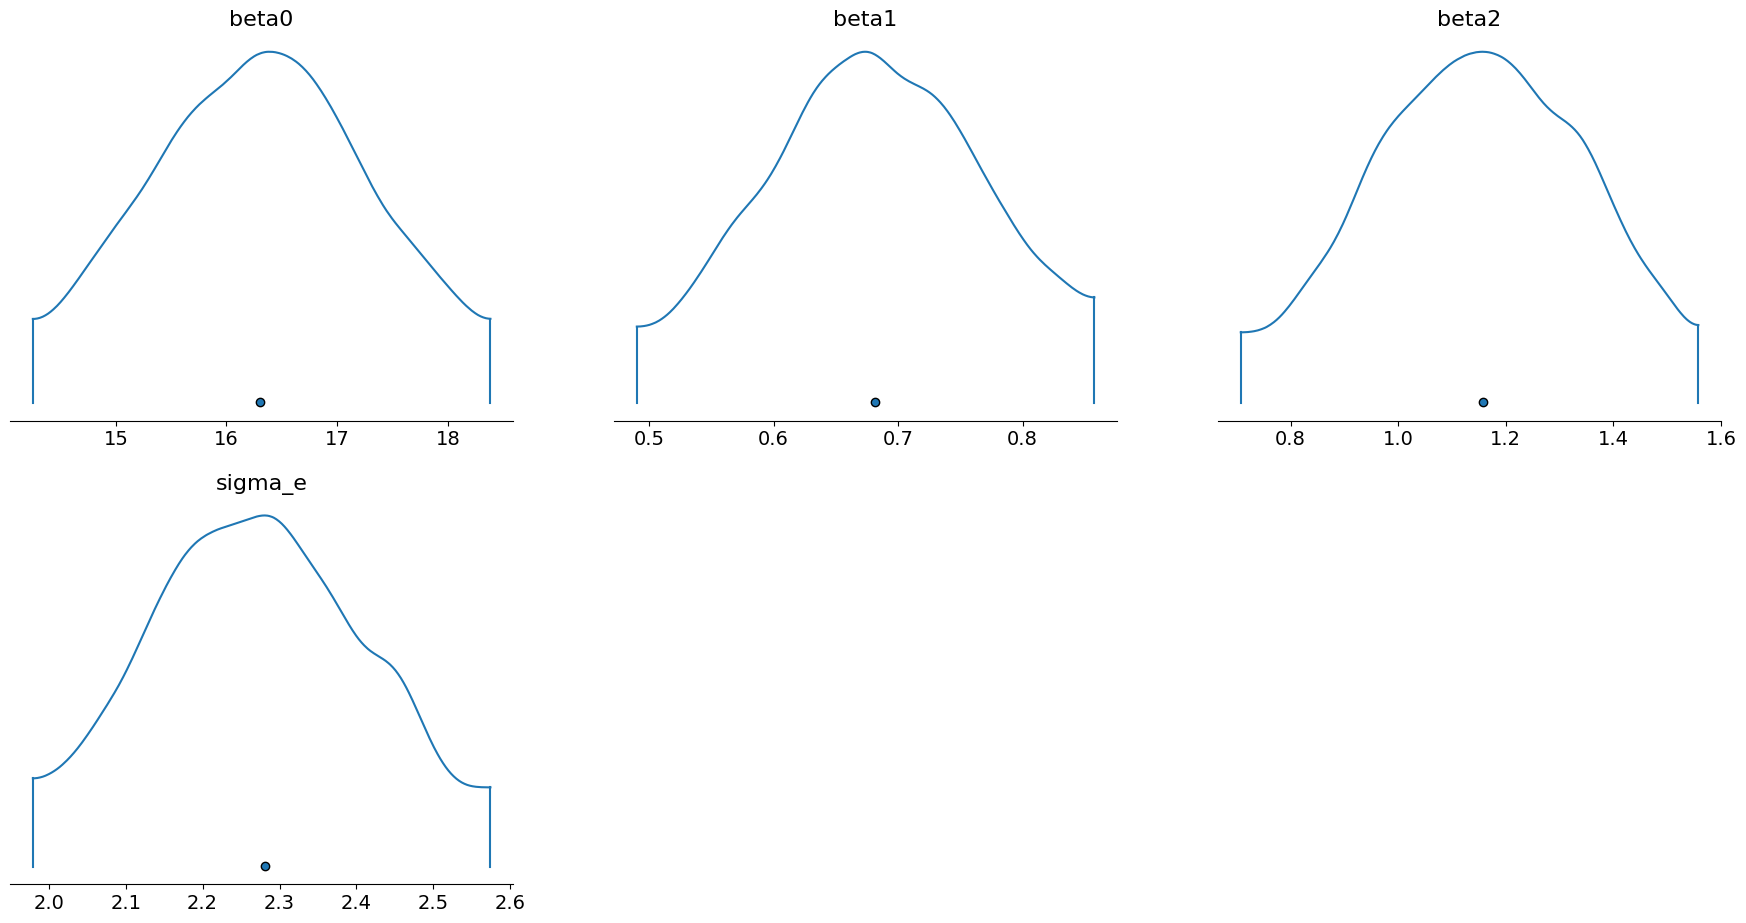

In [13]:
#Q2C: Plots of beta, beta1, beta2, and sigma_e
az.plot_density(trace.posterior, var_names=["beta0", "beta1", "beta2", "sigma_e"])

In [14]:
#Q3A:
data3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/shortleaf0-1.csv")
data3['logD'] = np.log(data3['D'])
data3['logH'] = np.log(data3['H'])
data3['logV'] = np.log(data3['V'])

with pm.Model() as m3:
  log_D_data = pm.Data('log_D_data', data3['logD'])
  log_H_data = pm.Data('log_H_data', data3['logH'])
  log_V_data = pm.Data('log_V_data', data3['logV'])

  gamma_0 = pm.Normal('gamma_0', mu=0, sigma=10) # Intercept
  gamma_1 = pm.Normal('gamma_1', mu=0, sigma=10) # Slope for log(D)
  gamma_2 = pm.Normal('gamma_2', mu=0, sigma=10) # Slope for log(H)

  tau = pm.Gamma("tau", alpha=0.01, beta=0.01)
  sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))
  mu = pm.Deterministic('mu', gamma_0 + gamma_1*log_D_data + gamma_2*log_H_data)
  y = pm.Normal('y', mu=mu, tau=tau, observed=log_V_data, shape=log_V_data.shape)

  trace = pm.sample(2000, tune=1500, target_accept = 0.95, random_seed = rng)
  ppc = pm.sample_posterior_predictive(trace, model=m3)



Output()

Output()

In [15]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma_0,-5.885,0.168,-6.228,-5.570,0.005,0.003,1104.0,1698.0,1.0
gamma_1,1.942,0.039,1.863,2.015,0.001,0.001,1200.0,1550.0,1.0
gamma_2,1.055,0.057,0.947,1.166,0.002,0.001,1015.0,1277.0,1.0
mu[0],0.829,0.020,0.791,0.870,0.000,0.000,2977.0,2703.0,1.0
mu[1],0.767,0.024,0.722,0.815,0.001,0.000,1951.0,2315.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[67],4.618,0.014,4.592,4.647,0.000,0.000,3599.0,3208.0,1.0
mu[68],4.666,0.015,4.638,4.699,0.000,0.000,3070.0,2835.0,1.0
mu[69],5.137,0.019,5.103,5.177,0.000,0.000,2978.0,2767.0,1.0
sigma,0.070,0.006,0.058,0.081,0.000,0.000,1884.0,1749.0,1.0


In [16]:
#Q3b)
#Formula: Log V = gamma0 + (gamma1 * log D) + (gamma2 * log H) + e
#gamma0, gamma1, gamma2 known: gamma_0 = -5.885, gamma_1 = 1.942, gamma_2 = 1.055
e = 1/208.848

log_fixed_D = np.array([np.log(15)])
log_fixed_H = np.array([np.log(89)])
log_fixed_V = np.array([0.0])

with m3:
    pm.set_data({
        'log_D_data': log_fixed_D,
        'log_H_data': log_fixed_H,
        'log_V_data': log_fixed_V
    })

ppc = pm.sample_posterior_predictive(
    trace,
    model=m3,
    var_names=["y"]
)

log_V_pred_samples = ppc.posterior_predictive['y'].stack(
    samples=("chain", "draw")
).values + e

V_pred_samples = np.exp(log_V_pred_samples)
print(V_pred_samples)
estimated_mean_V = np.mean(V_pred_samples)
cs_V = az.summary(V_pred_samples, hdi_prob=0.95)
print(estimated_mean_V)
print(cs_V)


Output()

Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


[[64.00202169 55.02906561 62.79423764 ... 69.91789354 62.41739331
  57.50955539]]
61.45901690274962
     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x  61.459  4.385    53.089     69.988      0.067    0.054    4223.0    3876.0   

   r_hat  
x    NaN  
